# Kings County Housing Prices Bakeoff

Below are a list of steps that you should take while trying to complete your bake-off entry.

## Step 1: Read in Data

In [344]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import warnings
import folium
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import scipy.stats as stats
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [345]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [346]:
#org_hous_df=pd.read_csv('Data/kc_house_data_train.csv', index_col='id').drop('Unnamed: 0', axis=1)
org_hous_df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
2591820310,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,0,4,8,2070,0,1986,0,98058,47.44,-122.16,2390,7700
7974200820,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,0,5,8,1830,1070,1977,0,98115,47.68,-122.28,2370,6283
7701450110,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,2,3,11,3770,0,1997,0,98006,47.56,-122.13,3710,9685
9522300010,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,2,3,12,4560,0,1990,0,98034,47.70,-122.23,4050,14226
9510861140,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,0,3,9,2550,0,2004,0,98052,47.66,-122.08,2250,4050


In [347]:
top5codes_price = org_hous_df.groupby("zipcode")["price"].mean().sort_values(ascending = False)[:5]
mean_price = org_hous_df.price.mean()
print(top5codes_price)

zipcode
98039   2202790.00
98004   1396882.89
98040   1183018.00
98112   1119457.66
98102    933671.47
Name: price, dtype: float64


In [348]:
count_by_zip = org_hous_df.groupby("zipcode")["price"].count().sort_values(ascending = False)[:70]
count_by_zip

zipcode
98052    474
98115    465
98103    461
98038    455
98117    437
        ... 
98102     80
98010     74
98024     65
98148     43
98039     42
Name: price, Length: 70, dtype: int64

In [351]:
mean_price_by_zip = org_hous_df.groupby("zipcode")["price"].mean().sort_values(ascending = False)[:70]
mean_price_by_zip = mean_price_by_zip.to_frame()
mean_price_by_zip['count'] = count_by_zip
mean_price_by_zip

,price,count
zipcode,,
98039,2202790.00,42
98004,1396882.89,237
98040,1183018.00,229
98112,1119457.66,216
98102,933671.47,80
...,...,...
98001,281998.76,284
98148,272082.33,43
98032,251602.23,103


In [352]:
no_bedrooms = org_hous_df[org_hous_df['bedrooms'] == 0]['price']
no_bathrooms = org_hous_df[org_hous_df['bathrooms'] == 0]['price']
stats.ttest_ind(no_bedrooms, no_bathrooms)

Ttest_indResult(statistic=-0.4158236996238441, pvalue=0.6824544554785027)

## Step 2: Exploratory Data Analysis 
    
Become familiar with the data.  Look to see if there are any extreme values.  

Additionally create data visualizations to determine if there are any relationships between your features and your target variables.  

In [353]:
org_hous_df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00,17290.00
mean,540739.55,3.37,2.11,2081.46,15243.40,1.49,0.01,0.24,3.41,7.65,1789.31,292.16,1970.79,83.81,98078.19,47.56,-122.21,1987.99,12873.48
std,373318.98,0.91,0.77,920.02,42304.62,0.54,0.09,0.78,0.65,1.17,829.27,443.15,29.34,400.33,53.61,0.14,0.14,684.80,27227.44
min,75000.00,0.00,0.00,290.00,572.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,659.00
25%,321000.00,3.00,1.50,1430.00,5081.25,1.00,0.00,0.00,3.00,7.00,1200.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5111.25
50%,450000.00,3.00,2.25,1920.00,7642.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1974.00,0.00,98065.00,47.57,-122.23,1840.00,7622.50
75%,645000.00,4.00,2.50,2550.00,10725.75,2.00,0.00,0.00,4.00,8.00,2214.50,560.00,1996.00,0.00,98118.00,47.68,-122.13,2360.00,10101.75
max,7700000.00,11.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,858132.00


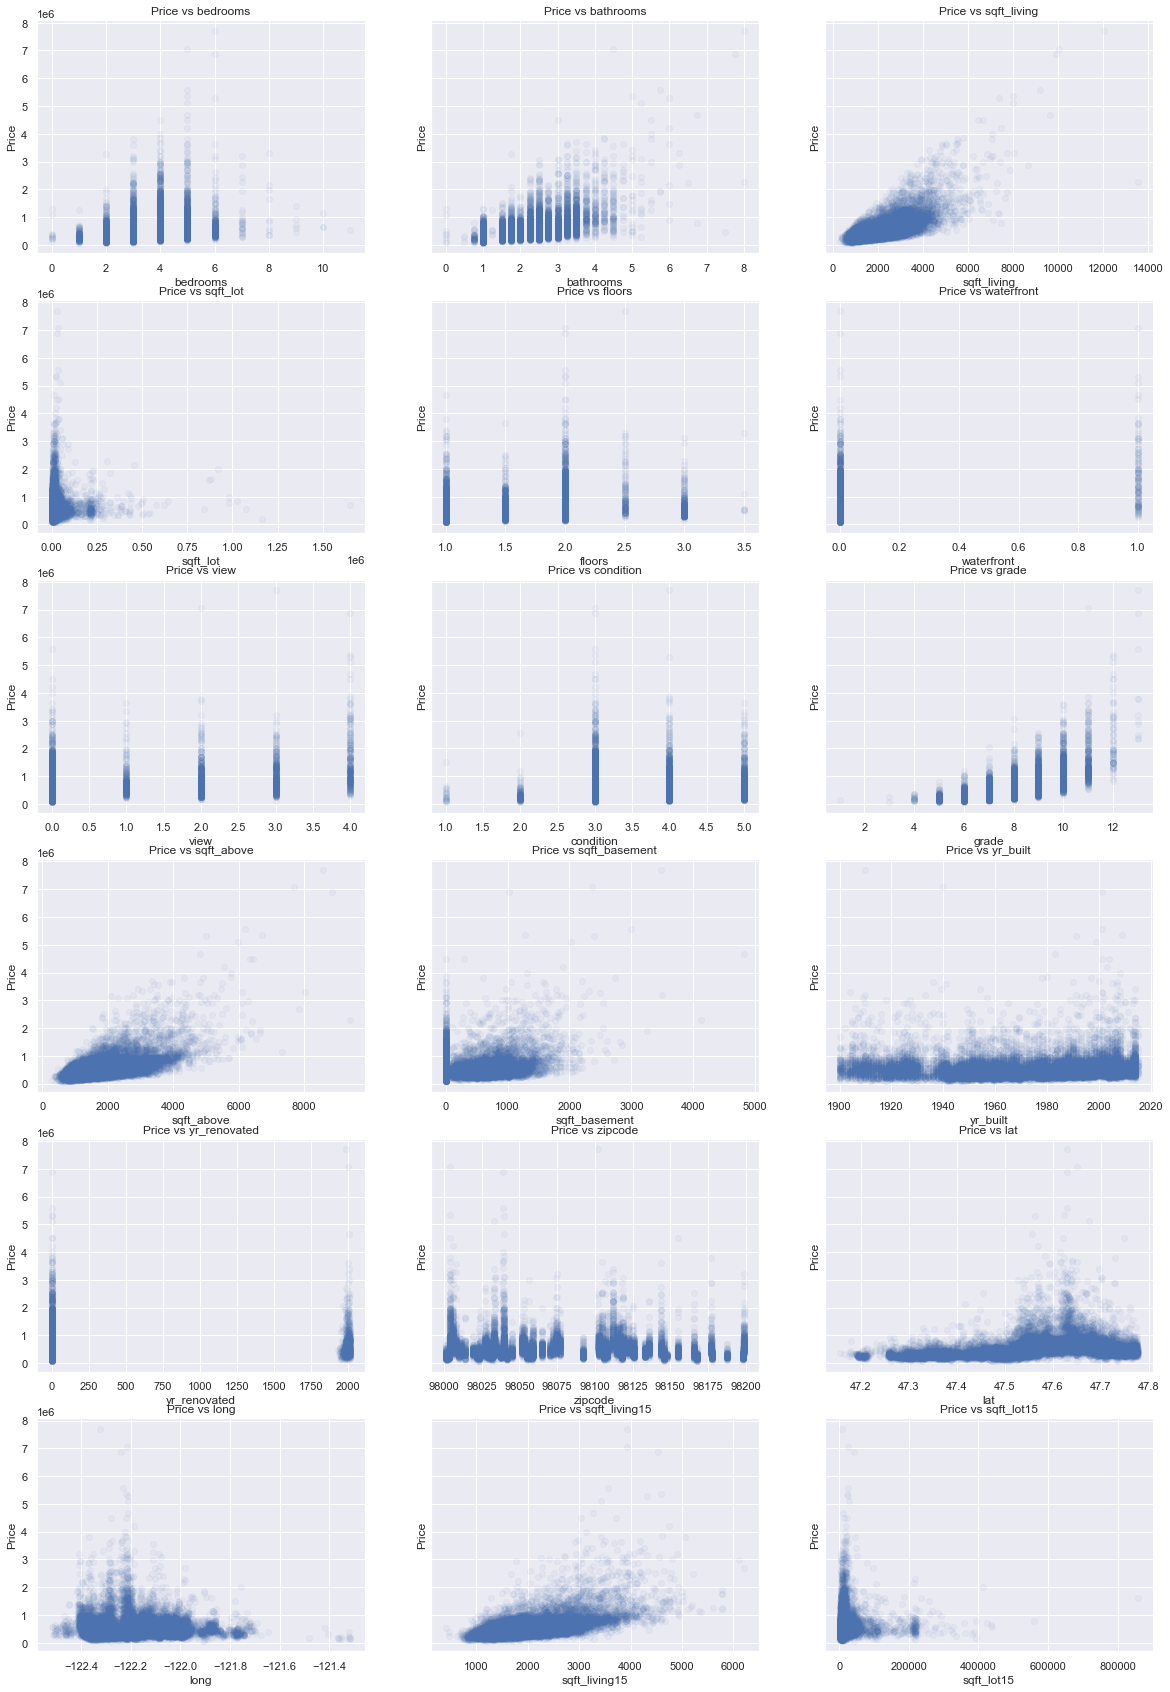

In [354]:
#Identify colinearity for all features with price with plots
fig, axes = plt.subplots(6, 3, figsize=(20,30), sharey=True)
for ax, column in zip(axes.flatten(), org_hous_df.columns[2:]):
    ax.scatter(org_hous_df[column], org_hous_df['price'], label=column, alpha=.05)
    ax.set_title(f'Price vs {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Price')

<AxesSubplot:xlabel='view'>

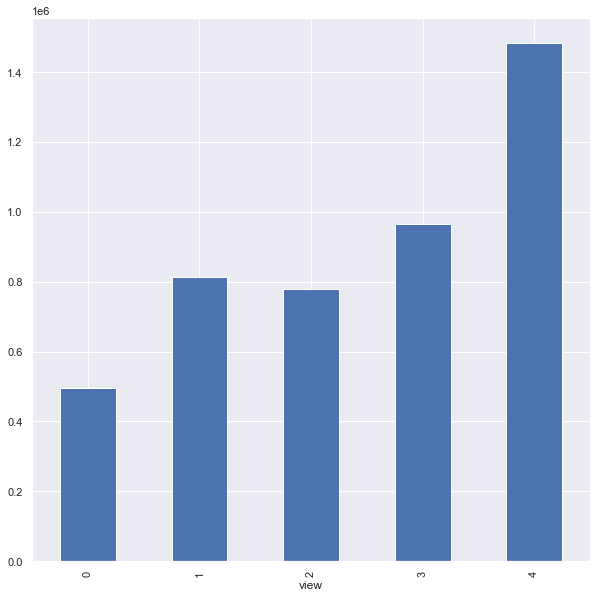

In [355]:
org_hous_df.groupby("view")["price"].mean().plot(kind='bar', figsize=(10,10))

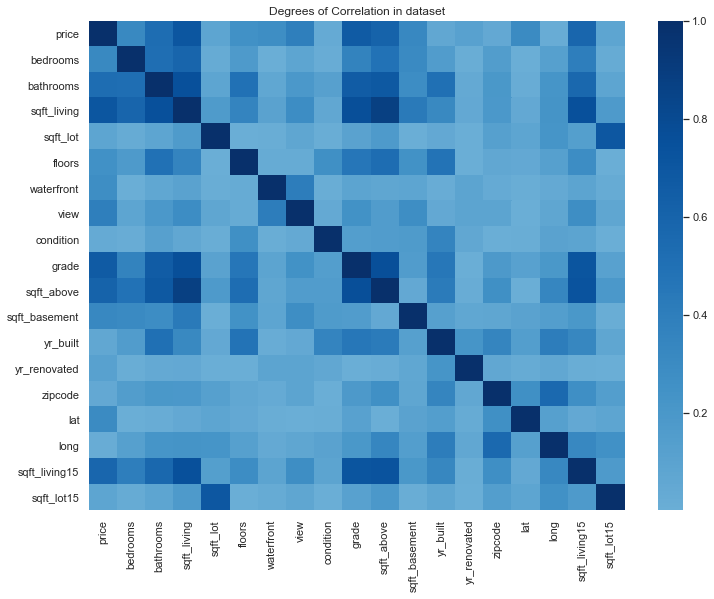

In [331]:
#corr = org_hous_df.corr().abs()
#sns.set(rc={'figure.figsize':(12,9)})
#sns.heatmap(corr[:20], xticklabels=corr[:20].columns, \
#            yticklabels=corr[:20].columns, \
#            annot=False, cmap='Blues', center= 0)
#plt.title('Degrees of Correlation in dataset');

In [ ]:
sns.set_palette('Blues_r')
x = ['98039', '98004', '98040', '98112', '98102']
y = [2.202790e+06, 1.396883e+06, 1.183018e+06, 1.119458e+06, 9.336715e+05]
fig, ax = plt.subplots(figsize = (15, 5))
ax = sns.barplot(x=x,y=y, data=org_hous_df)
ax.ticklabel_format(style='scientific', axis='y')

ax.set(xlabel='Zip Code', ylabel='Avg. Price')
plt.title("Average Home Price")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (12,6))
sns.distplot(org_hous_df['price'], bins=50, color = 'b')
ax.set(xlim=[0, 5000000], xlabel='Sale Price', ylabel='Sale Count',
       title='Sale Distribution')

In [ ]:
sns.set_theme(style='ticks', palette="rocket")
org_hous_df.hist(bins=50, figsize=(20,20))
plt.show()

In [ ]:
var = 'waterfront'
data = pd.concat([org_hous_df['price'], org_hous_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(10,8))
fig = sns.boxplot(x=var, y='price', data=data)

In [ ]:
var = 'grade'
data = pd.concat([org_hous_df['grade'], org_hous_df[var]], axis=1)
fig, ax = plt.subplots(figsize=(10,8))
fig = sns.boxplot(x=var, y='price', data=data)

In [ ]:
sns.scatterplot(data = org_hous_df, x = org_hous_df['price'], y = org_hous_df['sqft_living'])

plt.show()

In [ ]:
#folium Map using coordinates
kc_map = folium.Map(location = [47.5480, -121.9836], tiles = 'OpenStreetMap', zoom_start = 9)

kc_coord = list(zip(org_hous_df['lat'], org_hous_df['long']))

for coord in kc_coord:
    folium.Marker(location = coord).add_to(kc_map)

#kc_map

## Step 3: Clean up any issues (extreme values, etc.) with the data.  

Remember that you can't just delete rows with extreme values. Similar observations might be present in the holdout data set, and you can't just delete those rows and not have a prediction for it. 

In [ ]:
bedrooms - 33 bedroom house on Google Maps seems to be typo for a 3 bedroom house, twelve "studios" with no bedrooms
bathrooms - eight with no bathrooms

In [356]:
#correct 33 bedroom home
org_hous_df['bedrooms'].replace(33, 3, inplace=True)

In [439]:
#save cleaned df
org_hous_df.to_csv('~/Data', index=False)

## Step 4: Generate new features that you think could be important.

After doing this, you will want to go back to steps 2 and 3 to investigate these new features.

In [368]:
#yard_space column
org_hous_df['yard_space'] = org_hous_df.sqft_lot - (org_hous_df.sqft_living / org_hous_df.floors)

In [369]:
#multi_floor_column
org_hous_df['multi_floor'] = [0 if x == 1 else 1 for x in org_hous_df.floors] 

In [370]:
#Basement coulumn
org_hous_df['has_basement'] = [0 if x == 0 else 1 for x in org_hous_df.sqft_basement]

In [371]:
#sale_month column to explore affeect of seasons
org_hous_df['sale_month'] = pd.DatetimeIndex(org_hous_df['date']).month

In [372]:
#Year Renovated coulumn
org_hous_df['yr_built_reno'] = np.where((org_hous_df['yr_built'] < 1974) & (org_hous_df['yr_renovated'] == 0), 0,1)

### 4.1) Identify a categorical variable in the data set and create dummy columns.

In [384]:
# identified zipcode,grade and view
#org_hous_df=pd.get_dummies(org_hous_df, columns=['zipcode'], drop_first=True)
#org_hous_df=pd.get_dummies(org_hous_df, columns=['grade'], drop_first=True)
#org_hous_df=pd.get_dummies(org_hous_df, columns=['view'], drop_first=True)
org_hous_df.shape

(17290, 112)

### 4.3) There are columns for when the house was built and when it was renovated.  How could you use these columns to create a new column?

In [380]:
ols(formula='price~sqft_living', data= org_hous_df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                 1.694e+04
Date:                Fri, 04 Jun 2021   Prob (F-statistic):               0.00
Time:                        12:05:48   Log-Likelihood:            -2.4046e+05
No. Observations:               17290   AIC:                         4.809e+05
Df Residuals:                   17288   BIC:                         4.809e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5.347e+04   4991.006    -10.714      0.000   -6.33e+04   -4.37e+04
sqft_living   285.4779      2.193    130.167      0.000     281.179     289.777
==============================================================================
Omnibus:                    12367.474   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           507839.480
Skew:                           2.968   Prob(JB):                         0.00
Kurtosis:                      28.878   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <ins>Non-linear transformations</ins>

### 4.4) Create a polynomial feature for two of your continuous variables.

In [381]:
#org_hous_df['sqft_living^3'] = org_hous_df['sqft_living']**3
#org_hous_df['sqft_living^2'] = org_hous_df['sqft_living']**2
#org_hous_df['sqft_basement^2'] = org_hous_df['sqft_basement']**2
org_hous_df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,yard_space,multi_floor,has_basement,sale_month,yr_built_reno,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,sqft_living^3,sqft_living^2,sqft_basement^2
0,2591820310,20141006T000000,365000.00,4,2.25,2070,8893,2.00,0,4,2070,0,1986,0,47.44,-122.16,2390,7700,7858.00,1,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8869743000,4284900,0
1,7974200820,20140821T000000,865000.00,5,3.00,2900,6730,1.00,0,5,1830,1070,1977,0,47.68,-122.28,2370,6283,3830.00,0,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,24389000000,8410000,1144900
2,7701450110,20140815T000000,1038000.00,4,2.50,3770,10893,2.00,0,3,3770,0,1997,0,47.56,-122.13,3710,9685,9008.00,1,0,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,53582633000,14212900,0
3,9522300010,20150331T000000,1490000.00,3,3.50,4560,14608,2.00,0,3,4560,0,1990,0,47.70,-122.23,4050,14226,12328.00,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,94818816000,20793600,0
4,9510861140,20140714T000000,711000.00,3,2.50,2550,5376,2.00,0,3,2550,0,2004,0,47.66,-122.08,2250,4050,4101.00,1,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,16581375000,6502500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,627300195,20150303T000000,750000.00,5,2.50,3240,9960,1.00,0,3,2020,1220,1958,0,47.59,-122.11,2730,10400,6720.00,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,34012224000,10497600,1488400
17286,8819900270,20140520T000000,440000.00,2,1.75,1300,4000,2.00,0,3,1300,0,1948,0,47.67,-122.29,1350,4013,3350.00,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2197000000,1690000,0
1728

### 4.5) Create an interaction feature between a binary variable (dummy variable) and a continuous variable.

In [382]:
#sqft of homes sold with the best view
#org_hous_df['bestview_sqftliving'] = org_hous_df['view_4']*org_hous_df['sqft_living']

In [383]:
#zipcode with 474 houses sqft
#org_hous_df['biggestzipcode_sqftliving'] = org_hous_df['zipcode_98052']*org_hous_df['sqft_living']

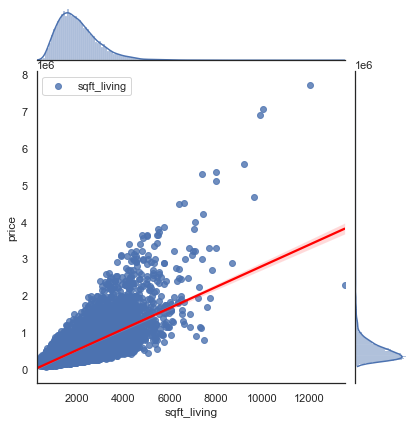

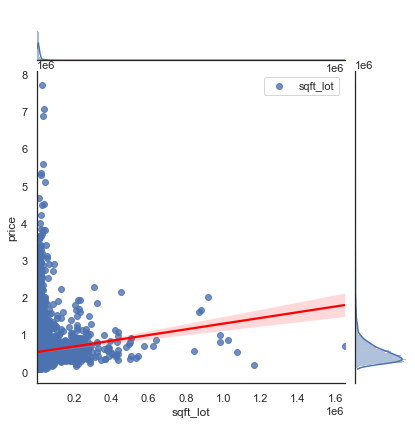

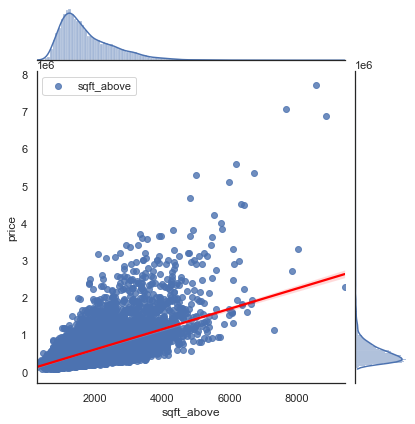

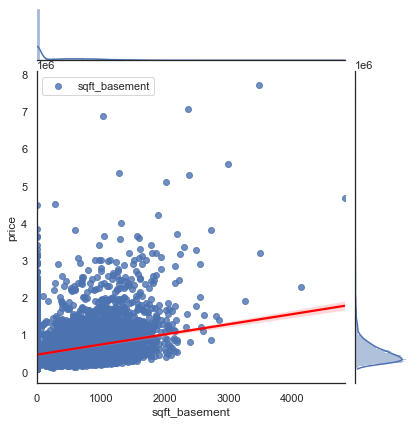

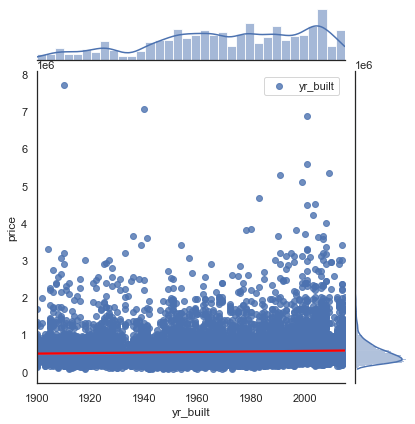

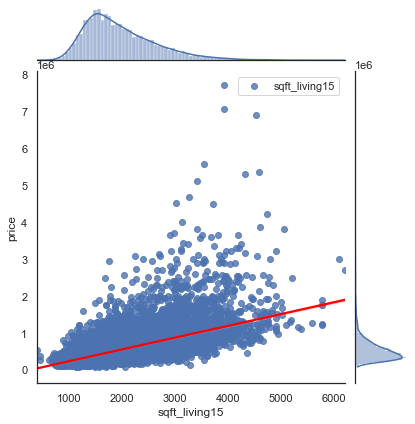

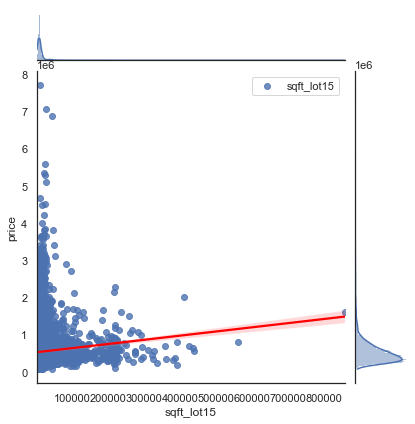

In [323]:
continuous = ['sqft_living','sqft_lot','sqft_above','sqft_basement','yr_built','sqft_living15','sqft_lot15']

for column in continuous:
    sns.jointplot(x=column, y="price", data=org_hous_df, kind='reg', label=column,joint_kws={'line_kws':{'color':'red'}})
    plt.legend()
    plt.show()

### 4.6) SKLearn Identifying Features 

In [272]:
features = ['second_sale', 'zipcode_98004', 'zipcode_98038', 'zipcode_98116','zipcode_98117','zipcode_98052',/
            'sale_month', 'yard_space', 'grade_3','grade_4','grade_5','grade_6','grade_7','grade_8','grade_9',/
            'grade_10','grade_11','grade_12','grade_13','view_1','view_2','view_3', 'view_4', 'sqft_living^2',/
            'been_renovated', 'sqft_living^3','sqft_basement^2', 'bestview_sqftliving', 'biggestzipcode_sqftliving']

In [396]:
df_features = org_hous_df.filter(org_hous_df.columns, axis=1)
df_features.drop(columns=['lat','long','date', 'id','price'], inplace=True)

In [397]:
df_features.drop( 'long', axis=1, inplace=True)

In [398]:
df_features.drop( 'date', axis=1, inplace=True)

In [399]:
df_features.drop( 'id', axis=1, inplace=True)

In [400]:
df_features.drop( 'price', axis=1, inplace=True)

In [401]:
target = org_hous_df['price']

In [402]:
len(df_features.columns)

107

In [403]:
from sklearn.linear_model import LinearRegression

#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(df_features, target)

#access output
print(lm.intercept_)
print(lm.coef_)
print("R^2: ", lm.score(df_features, target))

351674.964357443
[-5.48212678e+03  2.79310848e+04  2.22791561e+01 -8.91300191e+00
 -3.95293525e+04  5.90948124e+05  3.34994725e+04 -5.63046680e+00
  7.75424016e+00 -2.00454324e+02  3.31014329e+01  3.02918950e+01
 -7.28042820e-02  9.10278991e+00  1.11882511e+04 -1.37850192e+04
 -2.67747461e+03 -8.75194278e+03  4.82486239e+03 -1.12729683e+04
  7.67589366e+05  2.97530558e+05  2.42213600e+05  2.48321318e+05
  2.51838708e+05  5.95562057e+04  1.38300363e+05  9.98639731e+04
  9.53898345e+04 -6.33035595e+03 -3.22496284e+04  1.55722918e+05
  1.61216219e+05  1.32581173e+05  2.13833377e+05  4.50918047e+03
  1.31023612e+04  1.46956705e+03  3.52101320e+05  1.99394950e+05
  3.60516164e+04  1.17906455e+06  4.78509491e+05  6.13649452e+03
  9.71316240e+04  2.93256229e+05  1.98166846e+05  4.06746880e+04
  8.83291088e+04  3.22528909e+04  7.93248618e+04  8.84522628e+04
  2.72159949e+04  1.60130041e+05  1.79010947e+05  1.65437939e+05
  1.05724367e+05 -2.59867122e+04  4.82022094e+05  3.41663579e+05
  4.6984

In [404]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

In [ ]:
poly_data = poly.fit_transform(df_features)

In [408]:
df_features.isnull().value_counts

<bound method DataFrame.value_counts of        bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0         False      False        False     False   False       False   
1         False      False        False     False   False       False   
2         False      False        False     False   False       False   
3         False      False        False     False   False       False   
4         False      False        False     False   False       False   
...         ...        ...          ...       ...     ...         ...   
17285     False      False        False     False   False       False   
17286     False      False        False     False   False       False   
17287     False      False        False     False   False       False   
17288     False      False        False     False   False       False   
17289     False      False        False     False   False       False   

       condition  sqft_above  sqft_basement  yr_built  yr_renovated  \
0          F

## Step 5: Model Evaluation



## 5.1)  Fit an initial model and check the errors to see if the model assumptions are being met. If need be, go back to steps 3 and 4 to improve your model. 

In [ ]:
ols(formula='price~C(zipcode)+sqft_living+view', data= df_features).fit().summary()

In [409]:
len(df_features)

17290

In [411]:
poly_columns = poly.get_feature_names(df_features.columns)

In [412]:
len(poly_columns)

5989004

In [415]:
df_features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,yard_space,multi_floor,has_basement,sale_month,yr_built_reno,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_98107,zipcode_98108,zipcode_98109,zipcode_98112,zipcode_98115,zipcode_98116,zipcode_98117,zipcode_98118,zipcode_98119,zipcode_98122,zipcode_98125,zipcode_98126,zipcode_98133,zipcode_98136,zipcode_98144,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,sqft_living^3,sqft_living^2,sqft_basement^2,bestview_sqftliving,biggestzipcode_sqftliving
0,4,2.25,2070,8893,2.00,0,4,2070,0,1986,0,2390,7700,7858.00,1,0,10,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,8869743000,4284900,0,0,0
1,5,3.00,2900,6730,1.00,0,5,1830,1070,1977,0,2370,6283,3830.00,0,1,8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,24389000000,8410000,1144900,0,0
2,4,2.50,3770,10893,2.00,0,3,3770,0,1997,0,3710,9685,9008.00,1,0,8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,53582633000,14212900,0,0,0
3,3,3.50,4560,14608,2.00,0,3,4560,0,1990,0,4050,14226,12328.00,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,94818816000,20793600,0,0,0
4,3,2.50,2550,5376,2.00,0,3,2550,0,2004,0,2250,4050,4101.00,1,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,16581375000,6502500,0,0,2550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,5,2.50,3240,9960,1.00,0,3,2020,1220,1958,0,2730,10400,6720.00,0,1,3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,34012224000,10497600,1488400,0,0
17286,2,1.75,1300,4000,2.00,0,3,1300,0,1948,0,1350,4013,3350.00,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2197000000,1690000,0,0,0
17287,3,1.00,1050,9876,1.00,0,3,1050,0,1953,0,1760,9403,8826.00,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1157625000,1102500,0,0,0
17288,3,1.50,1900,43186,1.50,0,4,1300,600,1971,0,2080,1

In [416]:
df_poly = pd.DataFrame(poly_data, columns=poly_columns)

ValueError: Shape of passed values is (17288, 434), indices imply (17288, 5989004)

In [431]:
df_poly.head()

,second_sale,zipcode_98004,zipcode_98038,zipcode_98116,zipcode_98117,zipcode_98052,sale_month,yard_space,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,view_1,view_2,view_3,view_4,sqft_living^2,been_renovated,sqft_living^3,sqft_basement^2,bestview_sqftliving,second_sale^2,second_sale zipcode_98004,second_sale zipcode_98038,second_sale zipcode_98116,second_sale zipcode_98117,second_sale zipcode_98052,second_sale sale_month,second_sale yard_space,second_sale grade_3,second_sale grade_4,second_sale grade_5,second_sale grade_6,second_sale grade_7,second_sale grade_8,second_sale grade_9,second_sale grade_10,second_sale grade_11,second_sale grade_12,second_sale grade_13,second_sale view_1,second_sale view_2,second_sale view_3,second_sale view_4,second_sale sqft_living^2,second_sale been_renovated,second_sale sqft_living^3,second_sale sqft_basement^2,second_sale bestview_sqftliving,zipcode_98004^2,zipcode_98004 zipcode_98038,zipcode_98004 zipcode_98116,zipcode_98004 zipcode_98117,zipcode_98004 zipcode_98052,zipcode_98004 sale_month,zipcode_98004 yard_space,zipcode_98004 grade_3,zipcode_98004 grade_4,zipcode_98004 grade_5,zipcode_98004 grade_6,zipcode_98004 grade_7,zipcode_98004 grade_8,zipcode_98004 grade_9,zipcode_98004 grade_10,zipcode_98004 grade_11,zipcode_98004 grade_12,zipcode_98004 grade_13,zipcode_98004 view_1,zipcode_98004 view_2,zipcode_98004 view_3,zipcode_98004 view_4,zipcode_98004 sqft_living^2,zipcode_98004 been_renovated,zipcode_98004 sqft_living^3,zipcode_98004 sqft_basement^2,zipcode_98004 bestview_sqftliving,zipcode_98038^2,zipcode_98038 zipcode_98116,zipcode_98038 zipcode_98117,zipcode_98038 zipcode_98052,zipcode_98038 sale_month,zipcode_98038 yard_space,zipcode_98038 grade_3,zipcode_98038 grade_4,zipcode_98038 grade_5,zipcode_98038 grade_6,zipcode_98038 grade_7,zipcode_98038 grade_8,zipcode_98038 grade_9,zipcode_98038 grade_10,zipcode_98038 grade_11,zipcode_98038 grade_12,zipcode_98038 grade_13,zipcode_98038 view_1,zipcode_98038 view_2,zipcode_98038 view_3,zipcode_98038 view_4,zipcode_98038 sqft_living^2,zipcode_98038 been_renovated,zipcode_98038 sqft_living^3,zipcode_98038 sqft_basement^2,zipcode_98038 bestview_sqftliving,zipcode_98116^2,zipcode_98116 zipcode_98117,zipcode_98116 zipcode_98052,zipcode_98116 sale_month,zipcode_98116 yard_space,zipcode_98116 grade_3,zipcode_98116 grade_4,zipcode_98116 grade_5,zipcode_98116 grade_6,zipcode_98116 grade_7,zipcode_98116 grade_8,zipcode_98116 grade_9,zipcode_98116 grade_10,zipcode_98116 grade_11,zipcode_98116 grade_12,zipcode_98116 grade_13,zipcode_98116 view_1,zipcode_98116 view_2,zipcode_98116 view_3,zipcode_98116 view_4,zipcode_98116 sqft_living^2,zipcode_98116 been_renovated,zipcode_98116 sqft_living^3,zipcode_98116 sqft_basement^2,zipcode_98116 bestview_sqftliving,zipcode_98117^2,zipcode_98117 zipcode_98052,zipcode_98117 sale_month,zipcode_98117 yard_space,zipcode_98117 grade_3,zipcode_98117 grade_4,zipcode_98117 grade_5,zipcode_98117 grade_6,zipcode_98117 grade_7,zipcode_98117 grade_8,zipcode_98117 grade_9,zipcode_98117 grade_10,zipcode_98117 grade_11,zipcode_98117 grade_12,zipcode_98117 grade_13,zipcode_98117 view_1,zipcode_98117 view_2,zipcode_98117 view_3,zipcode_98117 view_4,zipcode_98117 sqft_living^2,zipcode_98117 been_renovated,zipcode_98117 sqft_living^3,zipcode_98117 sqft_basement^2,zipcode_98117 bestview_sqftliving,zipcode_98052^2,zipcode_98052 sale_month,zipcode_98052 yard_space,zipcode_98052 grade_3,zipcode_98052 grade_4,zipcode_98052 grade_5,zipcode_98052 grade_6,zipcode_98052 grade_7,zipcode_98052 grade_8,zipcode_98052 grade_9,zipcode_98052 grade_10,zipcode_98052 grade_11,zipcode_98052 grade_12,zipcode_98052 grade_13,zipcode_98052 view_1,zipcode_98052 view_2,zipcode_98052 view_3,zipcode_98052 view_4,zipcode_98052 sqft_living^2,zipcode_98052 been_renovated,zipcode_98052 sqft_living^3,zipcode_98052 sqft_basement^2,zipcode_98052 bestview_sqftliving,sale_month^2,sale_month yard_space,sale_month grade_3,sale_mon

In [223]:
poly_3 = PolynomialFeatures(degree=3, include_bias=False)
poly3_data = poly_3.fit_transform(df_features)
poly3_columns = poly_3.get_feature_names(df_features.columns)
df_poly3 = pd.DataFrame(poly3_data, columns=poly3_columns)

In [225]:
#instantiate a linear regression object
lm_2 = LinearRegression()

#fit the linear regression to the data
lm_2 = lm_2.fit(df_poly, target)

#access output
# print(lm_2.intercept_)
# print(lm_2.coef_)
print("R^2: ", lm_2.score(df_poly, target))

R^2:  0.6101987114852564


In [226]:
#instantiate a linear regression object
lm_3 = LinearRegression()

#fit the linear regression to the data
lm_3 = lm_3.fit(df_poly3, target)

#access output
# print(lm_3.intercept_)
# print(lm_3.coef_)
print("R^2: ", lm_3.score(df_poly3, target))

R^2:  0.5576160776298682


In [430]:
df_features.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'sqft_above', 'sqft_basement', 'yr_built',
       ...
       'grade_13', 'view_1', 'view_2', 'view_3', 'view_4', 'sqft_living^3',
       'sqft_living^2', 'sqft_basement^2', 'bestview_sqftliving',
       'biggestzipcode_sqftliving'],
      dtype='object', length=107)

### 5.2) Perform a train-test split of the data.

In [278]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, random_state=9,test_size=0.3)

In [417]:
X_train, X_test, y_train, y_test = train_test_split(df_features, target, test_size=0.3, random_state=34)
print(len(X_train), len(X_test), len(y_train), len(y_test))

12103 5187 12103 5187


### 5.3) Fit the model to the training data.

In [418]:
y_train

14093    940000.00
4974     213500.00
14746    765000.00
10649   1250000.00
10927    728935.00
           ...    
16708    300000.00
3157     515000.00
10730    400000.00
5242     715000.00
11681    270000.00
Name: price, Length: 12103, dtype: float64

In [419]:
target.head()

0    365000.00
1    865000.00
2   1038000.00
3   1490000.00
4    711000.00
Name: price, dtype: float64

In [282]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

#transform the training data
scaled_data = scaler.transform(X_train)

#create dataframe
X_train = pd.DataFrame(data=scaled_data, columns=df_features.columns)

#transform the testing dat
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=df_features.columns)

### 5.4) Use the model to predict on the training set and the test set.

In [420]:
#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)

Training set - Features:  (12103, 107) Target:  (12103,)
Training set - Features:  (5187, 107) Target:  (5187,)


### 5.5) Evaluate the training and test predictions using RMSE.

### 5.6) Determine if your model is overfit.

In [421]:
def test_data(df_features, target):
    testtrainsplit
    lm = LinearRegression()
    lm.fit()
    return RMSE

In [422]:
df1_rmse = test_data(org_hous_df)

TypeError: test_data() missing 1 required positional argument: 'target'

## Step 6: Utilize some different feature selection techniques before or in conjuction with fitting your models. You will have to repeat steps 5.3 through 5.6 to determine how your new model is performing. 

### 6.1) Utilize a filter method to identify some features to remove from the model.  

In [423]:
X_train.shape

(12103, 107)

In [424]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

selector = SelectKBest(f_regression, k='all')

selector.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_regression at 0x7ff5618ccca0>)

In [425]:
selector.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [426]:
selected_columns = X_train.columns[selector.get_support()]
removed_columns = X_train.columns[~selector.get_support()]
#X_train = X_train[selected_columns]
#X_test = X_test[selected_columns]

In [427]:
list(selected_columns)

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'sqft_living15',
 'sqft_lot15',
 'yard_space',
 'multi_floor',
 'has_basement',
 'sale_month',
 'yr_built_reno',
 'zipcode_98002',
 'zipcode_98003',
 'zipcode_98004',
 'zipcode_98005',
 'zipcode_98006',
 'zipcode_98007',
 'zipcode_98008',
 'zipcode_98010',
 'zipcode_98011',
 'zipcode_98014',
 'zipcode_98019',
 'zipcode_98022',
 'zipcode_98023',
 'zipcode_98024',
 'zipcode_98027',
 'zipcode_98028',
 'zipcode_98029',
 'zipcode_98030',
 'zipcode_98031',
 'zipcode_98032',
 'zipcode_98033',
 'zipcode_98034',
 'zipcode_98038',
 'zipcode_98039',
 'zipcode_98040',
 'zipcode_98042',
 'zipcode_98045',
 'zipcode_98052',
 'zipcode_98053',
 'zipcode_98055',
 'zipcode_98056',
 'zipcode_98058',
 'zipcode_98059',
 'zipcode_98065',
 'zipcode_98070',
 'zipcode_98072',
 'zipcode_98074',
 'zipcode_98075',
 'zipcode_98077',
 'zipcode_98092',
 'zipco

### 6.2) After removing the features, re-run Step 5 and see if your new model performs better than the old model.

In [428]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set(style="darkgrid")

<AxesSubplot:>

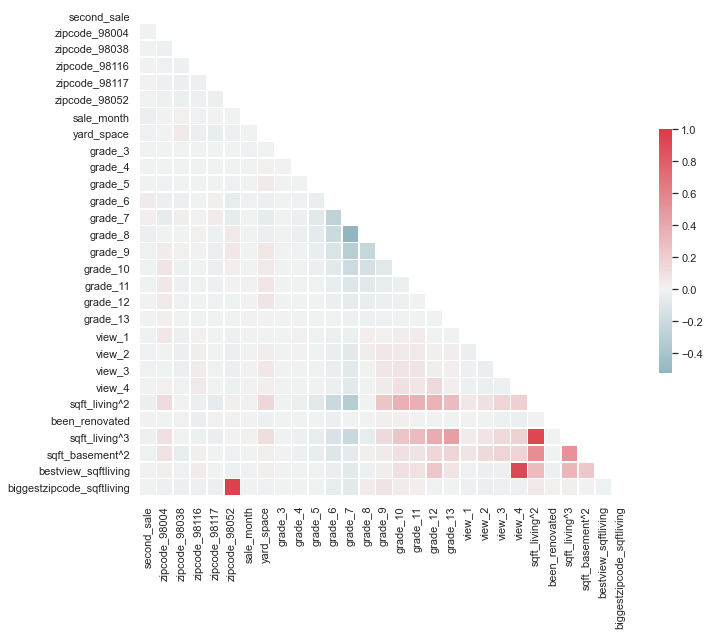

In [295]:

sns.set(style="white")


# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [434]:
df_features.shape

(17290, 107)

In [435]:
target.shape

(17290,)

In [436]:
#instantiate a linear regression object
lm_kbest = LinearRegression()

#fit the linear regression to the data
lm_kbest.fit(df_features, target)

y_train_kbest = lm_kbest.predict(df_features)


#trainK_rmse = np.sqrt(metrics.mean_squared_error(y_train, y_train_kbest))


#print('Training Root Mean Squared Error:' , trainK_rmse)

#y_kbest = lm_kbest.predict(X_test)

#testK_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_kbest))

#print('Testing Root Mean Squared Error:' , testK_rmse)

In [437]:
import pickle

pickle_out = open("model.pickle","wb")

pickle.dump(lm, pickle_out)

pickle_out.close()

In [438]:
pickle_out = open("column_selection.pickle","wb")

pickle.dump(df_features.columns, pickle_out)

pickle_out.close()

## Step 7: Compare the RMSE of your different models that use different features and determine the best model overall.

## Step 8:  Refit your best model to the entire dataset.

## Step 9: Save your final model using pickle.

https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/